# **-------**>**DIABETES PREDICTION USING MACHINE LEARNING PROJECT**<**-------**

# Step 1: Import Necessary Libraries

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Step 2: Load the Dataset

In [99]:
# Load the dataset
file_path = r'D:\# DATA SCIENCE\# PROJECTS\- PROJECTS INTERNSHIPS\TECHNOHACKS SOLUTIONS - MACHINE LEARNING ENGINEERING\Diabetes Prediction Project\diabetes.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


# Step 3: Data Cleaning

In [100]:
# Drop duplicates
df = df.drop_duplicates()

# Check for missing values and handle them using KNN Imputation
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Check if there are still missing values
print(df_imputed.isnull().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

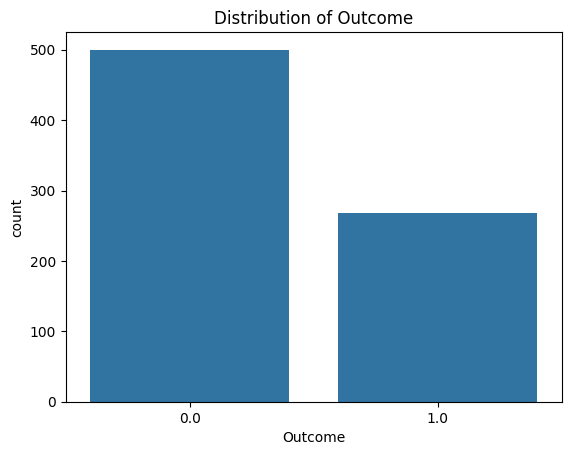

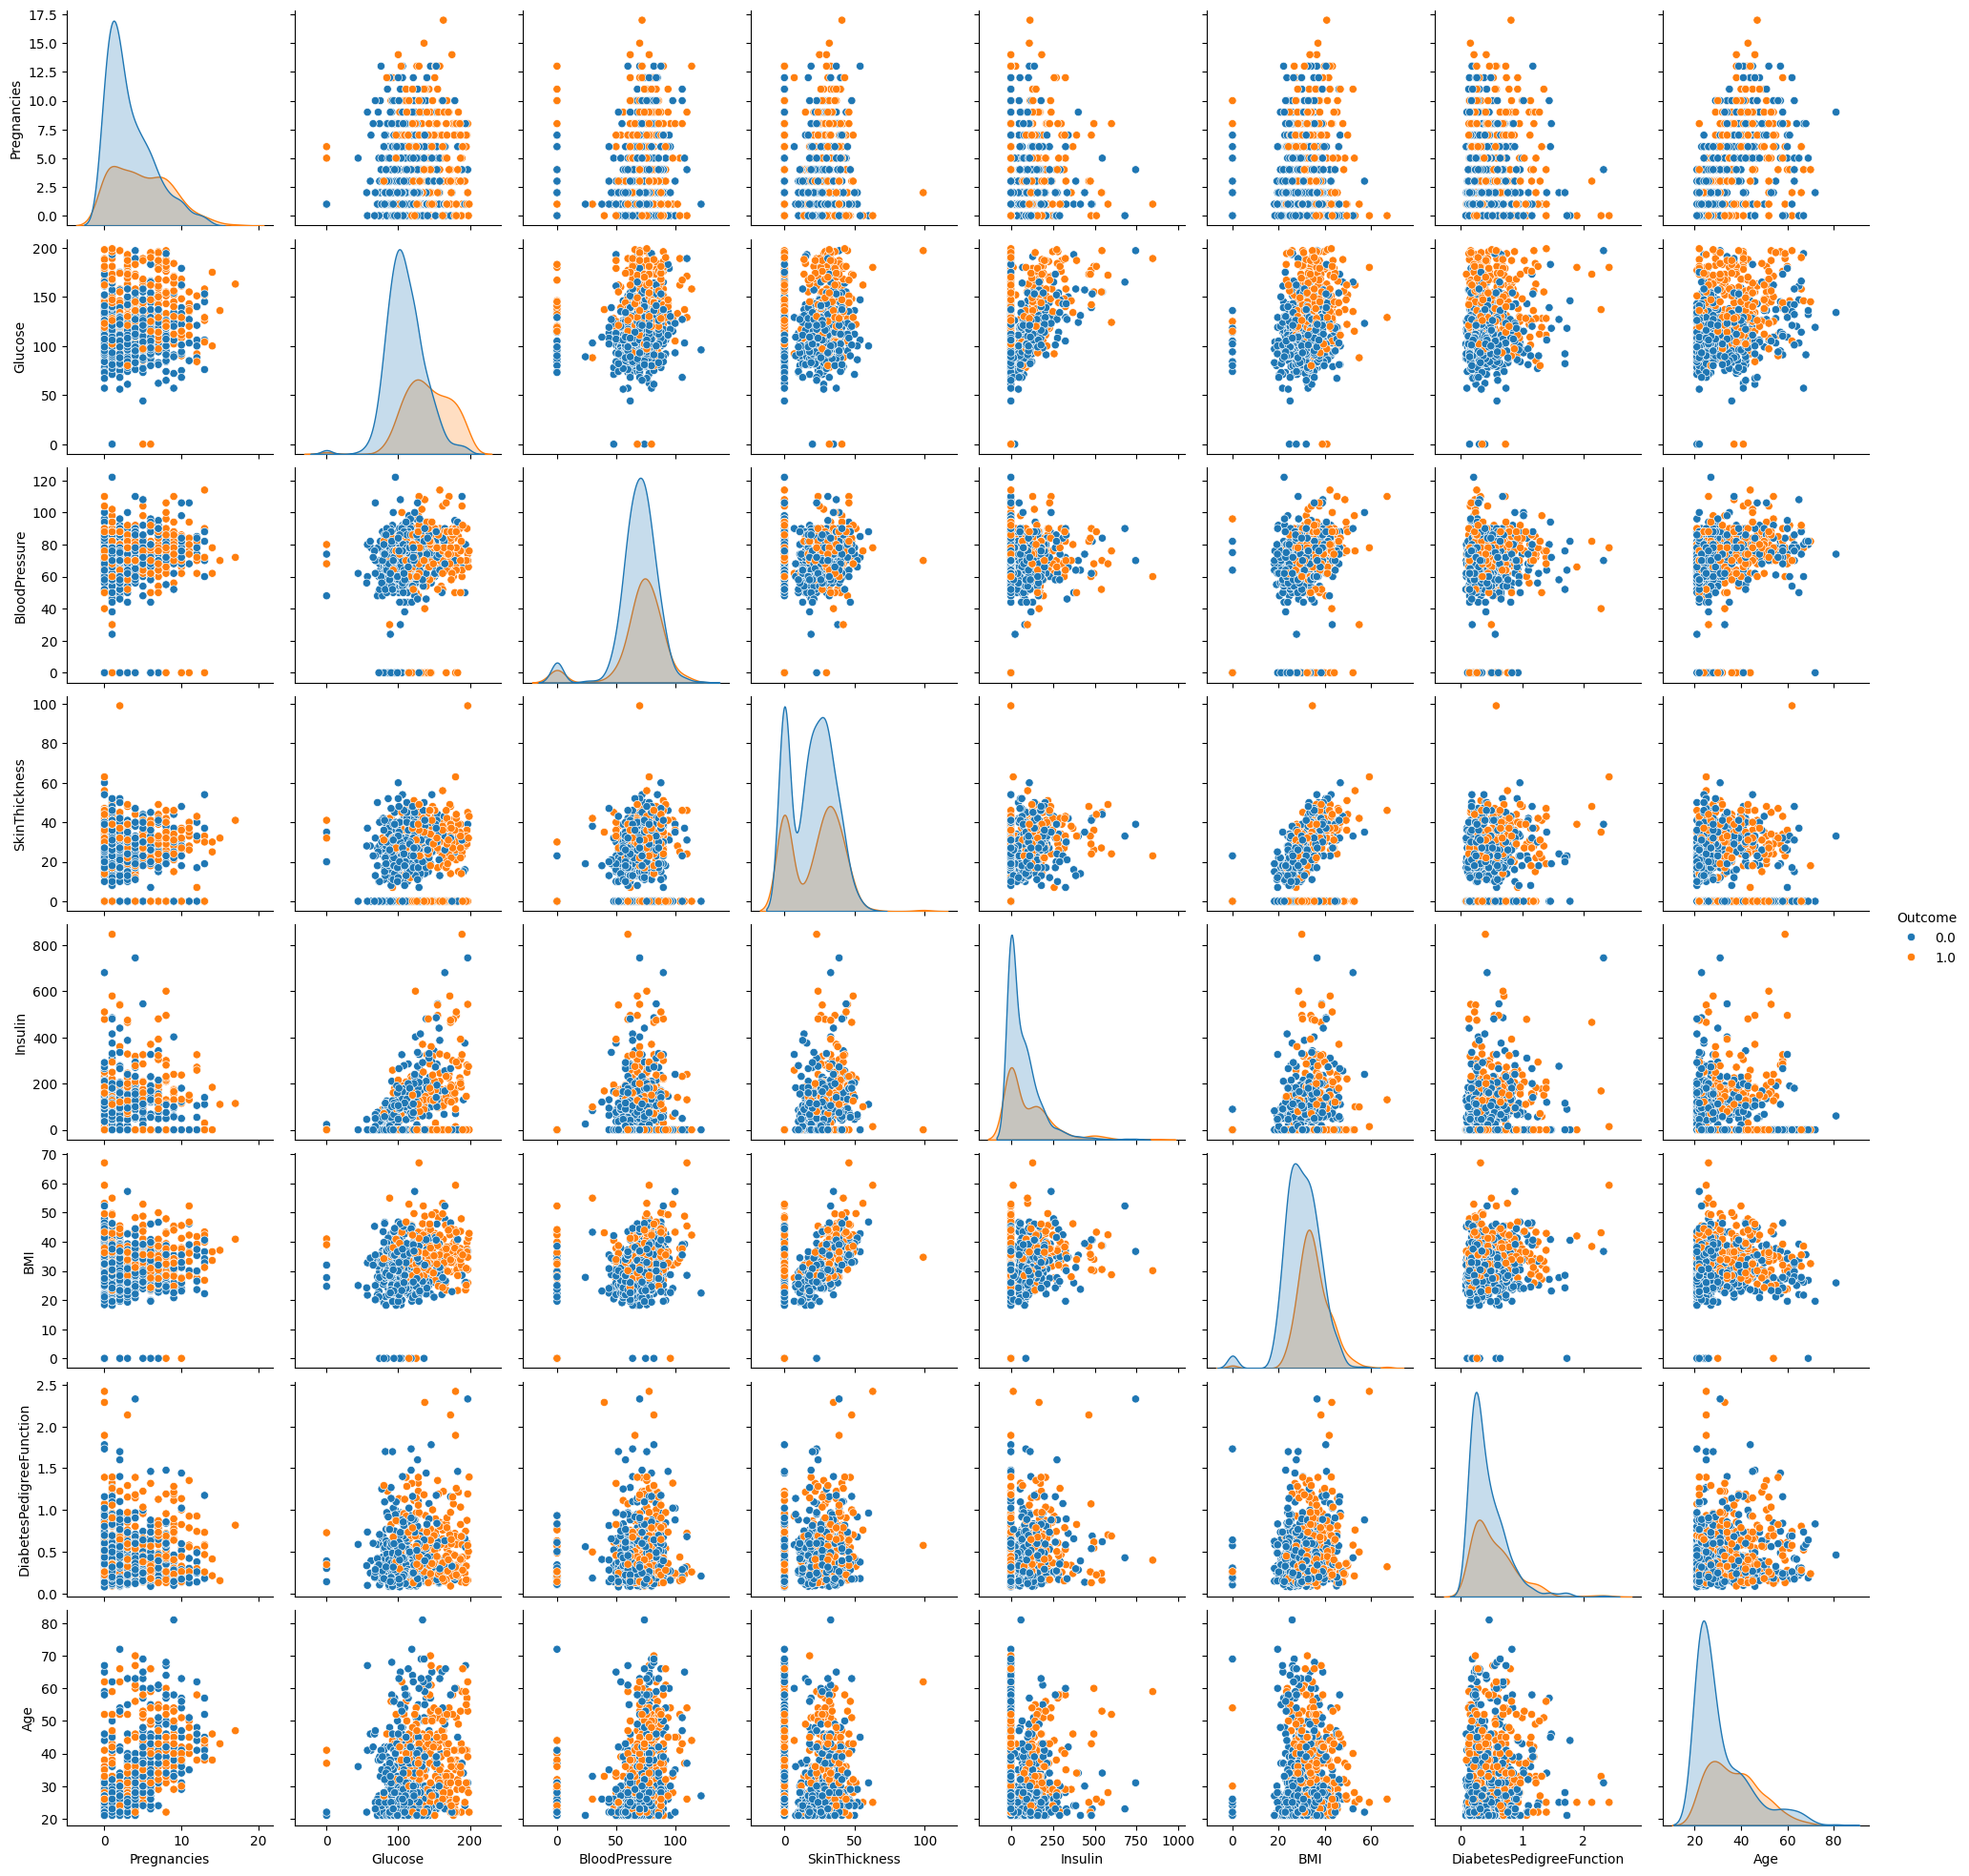

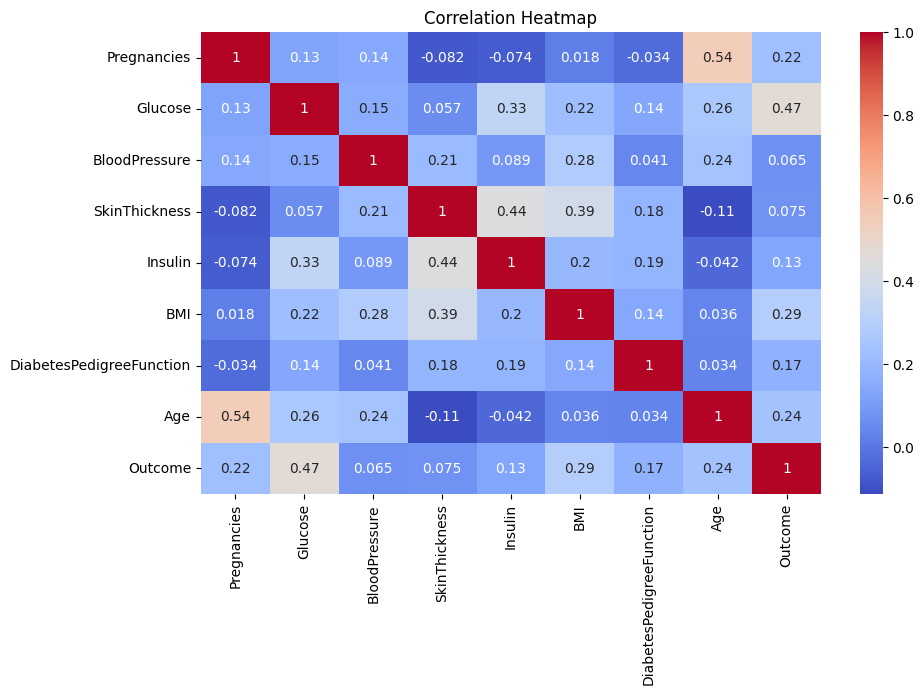

In [101]:
# Statistical summary
print(df_imputed.describe())

# Checking the distribution of the target variable
sns.countplot(x='Outcome', data=df_imputed)
plt.title('Distribution of Outcome')
plt.show()

# Visualizing relationships between features
sns.pairplot(df_imputed, hue='Outcome')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# 4. Handling Outliers

In [102]:
# Import necessary libraries
from scipy import stats
from scipy.stats.mstats import winsorize

# Define the columns from your dataset
columns= ['Pregnancies', 'SkinThickness', 'Insulin', 'Age', 'Outcome']

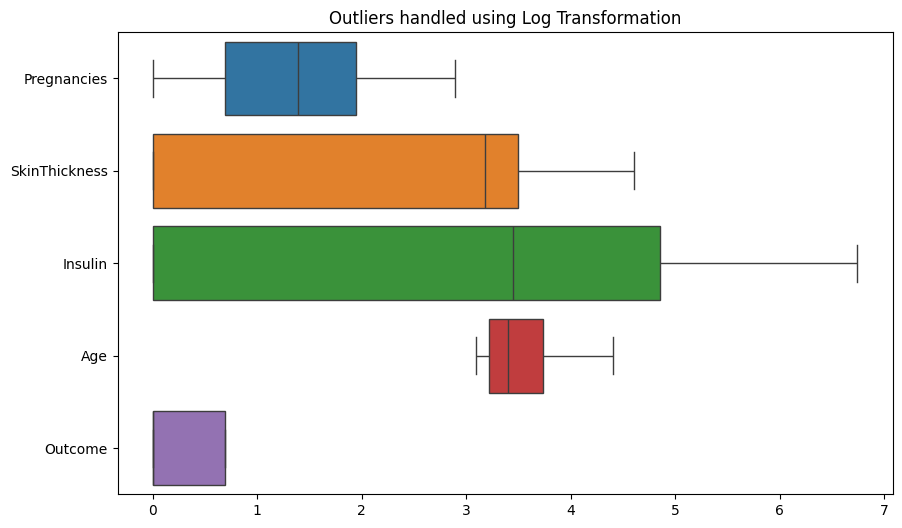

In [103]:
# Log Transformation to handle outliers
def log_transform(df):
    df_log_transformed = df.copy()
    for col in columns:
        df_log_transformed[col] = np.log1p(df[col])  # log1p is used to handle zeros in the data
    return df_log_transformed

# Apply the Log Transformation
df_log_transformed = log_transform(df[columns])

# Plot the box plot for Log Transformation method
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_log_transformed, orient="h")
plt.title('Outliers handled using Log Transformation')
plt.show()


In [104]:
columns2 = ['Glucose']

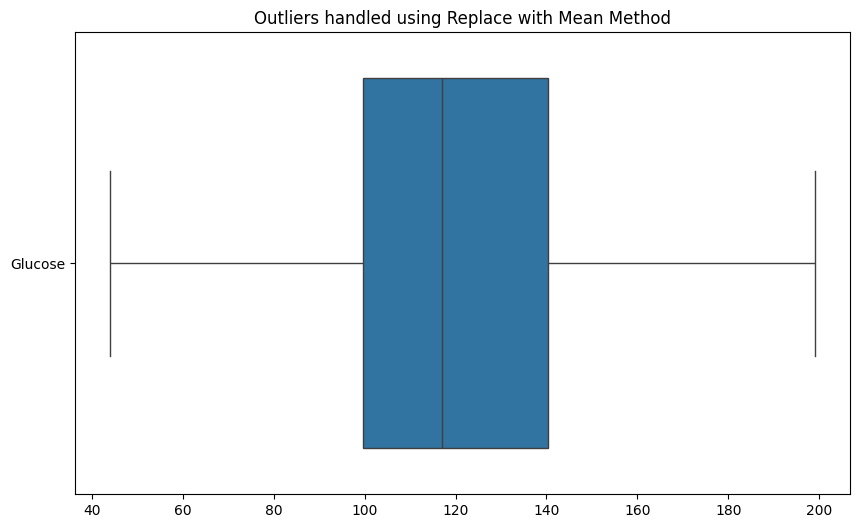

In [105]:
# Replace outliers with mean
def replace_outliers_with_mean(df):
    df_replaced = df.copy()
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    for col in columns2:
        lower_bound = Q1[col] - 1.5 * IQR[col]
        upper_bound = Q3[col] + 1.5 * IQR[col]
        mean = df[col].mean()
        df_replaced[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), mean, df[col])
    return df_replaced

# Apply the Replace with Mean method
df_mean_replaced = replace_outliers_with_mean(df[columns2])

# Plot the box plot for Replace with Mean method
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_mean_replaced, orient="h")
plt.title('Outliers handled using Replace with Mean Method')
plt.show()


In [106]:
columns3 = ['BloodPressure', 'BMI', 'DiabetesPedigreeFunction']

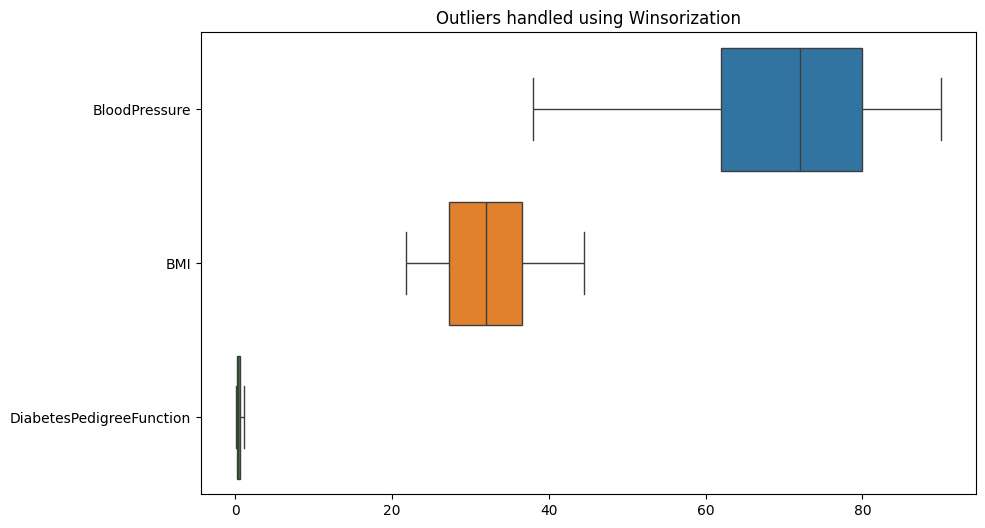

In [107]:
from scipy.stats.mstats import winsorize

# Winsorization Transformation to handle outliers
def winsorize_transform(df, limits=[0.05, 0.05]):
    df_winsorized = df.copy()
    for col in columns3:
        df_winsorized[col] = winsorize(df_winsorized[col], limits=limits)  # Winsorize data by capping extremes
    return df_winsorized

# Apply the Winsorization Transformation
df_winsorized = winsorize_transform(df)

# Plot the box plot for Winsorization method
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_winsorized[columns3], orient="h")
plt.title('Outliers handled using Winsorization')
plt.show()


# Step 5: Data Preprocessing

In [108]:
# Splitting the data into features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Model Building

In [109]:
# Importing necessary libraries for cross-validation and hyperparameter tuning
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# Defining the parameter grid for RandomizedSearchCV for SVM
param_grid = {
    'C': [0.1, 1, 10],                     # Regularization parameter
    'kernel': ['linear', 'rbf'],           # Specifies the kernel type
    'gamma': ['scale', 'auto'] + [0.001, 0.01],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid' 
    'degree': [2, 3]                       # Degree of the polynomial kernel function ('poly')
}

# Initializing SVC with probability=True
model = SVC(random_state=99, probability=True)

# Setting up Stratified K-Folds cross-validator with 10 folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=99) 

# Performing RandomizedSearchCV with 10-fold cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50, 
                                   cv=cv, verbose=2, random_state=99, n_jobs=-1)

# Fitting the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Printing the best hyperparameters found by RandomizedSearchCV
print(f"Best Hyperparameters: {random_search.best_params_}")

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.01, 'degree': 2, 'C': 1}


# Step 7: Model Evaluation

Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       100
           1       0.77      0.56      0.65        54

    accuracy                           0.79       154
   macro avg       0.78      0.73      0.75       154
weighted avg       0.78      0.79      0.78       154



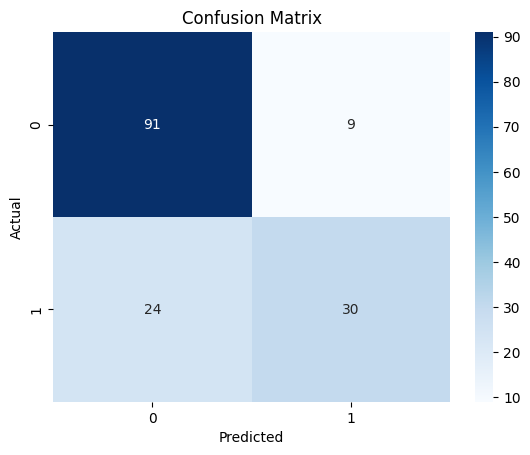

In [110]:
# Using the best estimator from RandomizedSearchCV to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

AUC: 0.84


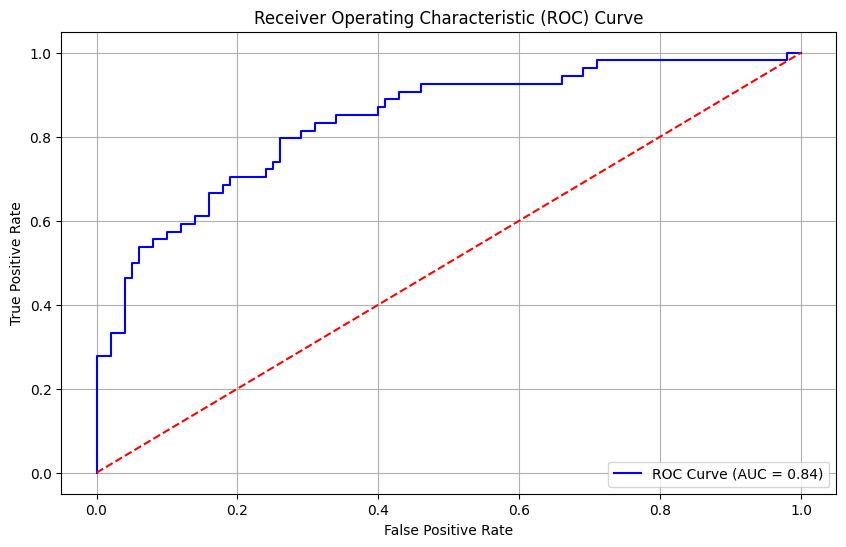

In [111]:
# ROC Curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {auc:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Step 8: Feature Importance

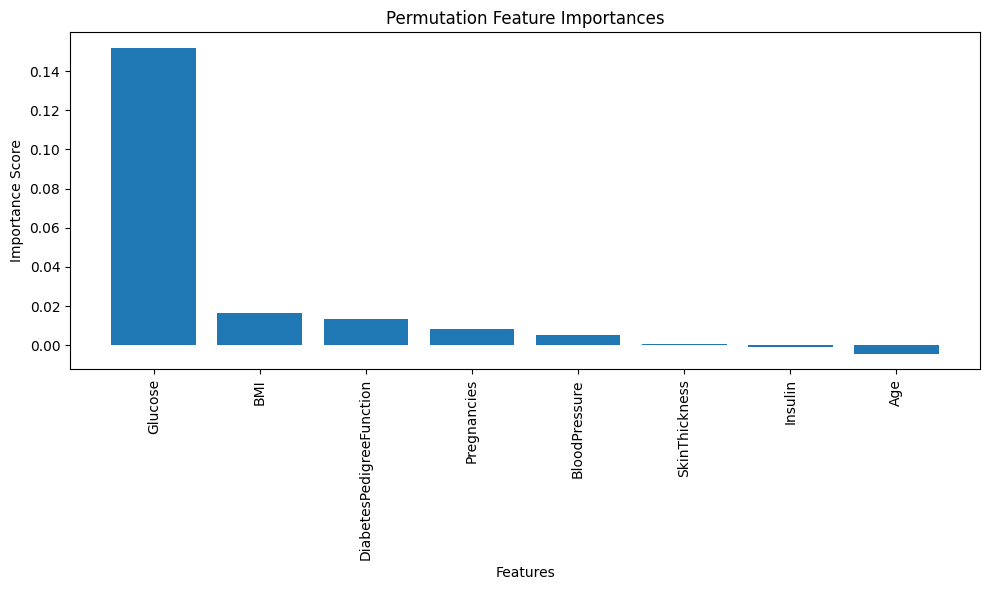

In [112]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance for the best model
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=99, n_jobs=-1)

# Get the importances
importances = result.importances_mean

# Sort the importances
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Permutation Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()
